In [ ]:
import io
import os
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
from transformers import PaliGemmaProcessor
from datasets import load_dataset, Dataset

# Path to JSON file
train_json_path = "Train data comprised 60% of the dataset.json"

dataset = load_dataset("json", data_files={"train": train_json_path})

def transform_format(example):
    return {
        "id": example["id"],
        "image": example["image"],
        "Question": example["conversations"][0]["value"],
        "Answer": example["conversations"][1]["value"],
    }

dataset = dataset.map(transform_format)

def load_images_as_pil(dataset):
    updated_entries = []
    for example in dataset:
        image_path = f"./Demoface/{example['image']}"
        try:
            pil_image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            pil_image = None

        updated_entries.append({
            "image": pil_image,
            "Question": example["Question"],
            "Answer": example["Answer"],
        })
    return updated_entries

dataset = load_images_as_pil(dataset["train"])

def pil_image_to_bytes(image):
    buf = io.BytesIO()
    image.save(buf, format='JPEG')
    return buf.getvalue()

def bytes_to_pil_image(byte_data):
    return Image.open(io.BytesIO(byte_data))

data_dict = {
    "image": [bytes_to_pil_image(pil_image_to_bytes(item["image"])) for item in dataset],
    "Question": [item["Question"] for item in dataset],
    "Answer": [item["Answer"] for item in dataset]
}

dataset = Dataset.from_dict(data_dict)

print(dataset)

/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map: 100%|██████████████████████████████████████| 18144/18144 [00:00<00:00, 34358.83 examples/s]


Dataset({
    features: ['image', 'Question', 'Answer'],
    num_rows: 18144
})


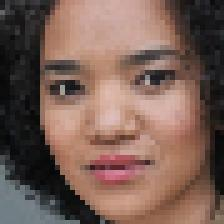

In [ ]:
dataset[1]["image"]

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch.nn.utils.rnn import pad_sequence
from PIL import Image
import io


def bytes_to_pil_image(byte_data):
    return Image.open(io.BytesIO(byte_data))


class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"] , padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        litem=item['Answer']
        litem=litem.split(',')[-2]+litem.split(',')[-1]
        encoding["text"] = litem
        encoding["question"] = item['Question']
        return encoding


import torch
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    processed_batch = {}

    # Process image encodings
    for key in batch[0].keys():
        if key not in ["text", "question"]:
            processed_batch[key] = torch.stack([example[key] for example in batch])

    # Process questions
    question_inputs = processor.tokenizer(
        [example["question"] for example in batch], padding=True, return_tensors="pt"
    )
    processed_batch["question_input_ids"] = question_inputs["input_ids"]
    processed_batch["question_attention_mask"] = question_inputs["attention_mask"]

    # Process answers (text)
    text_inputs = processor.tokenizer(
        [example["text"] for example in batch], padding=True, return_tensors="pt"
    )
    processed_batch["input_ids"] = text_inputs["input_ids"]
    processed_batch["attention_mask"] = text_inputs["attention_mask"]

    return processed_batch



In [ ]:
from peft import LoraConfig, get_peft_model
from transformers import AutoProcessor, Blip2ForConditionalGeneration, BitsAndBytesConfig

quant_config = BitsAndBytesConfig(load_in_8bit=True)

# Load from local path
processor = AutoProcessor.from_pretrained("./blip2_local_downloaded_path")
model = Blip2ForConditionalGeneration.from_pretrained("./blip2_local_downloaded_path", device_map="cuda:0", quantization_config=quant_config)

# Define LoraConfig
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=6, collate_fn=collate_fn)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)


Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


trainable params: 5,242,880 || all params: 3,749,922,816 || trainable%: 0.1398


PeftModel(
  (base_model): LoraModel(
    (model): Blip2ForConditionalGeneration(
      (vision_model): Blip2VisionModel(
        (embeddings): Blip2VisionEmbeddings(
          (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
        )
        (encoder): Blip2Encoder(
          (layers): ModuleList(
            (0-38): 39 x Blip2EncoderLayer(
              (self_attn): Blip2Attention(
                (dropout): Dropout(p=0.0, inplace=False)
                (qkv): Linear8bitLt(in_features=1408, out_features=4224, bias=True)
                (projection): Linear8bitLt(in_features=1408, out_features=1408, bias=True)
              )
              (layer_norm1): LayerNorm((1408,), eps=1e-05, elementwise_affine=True)
              (mlp): Blip2MLP(
                (activation_fn): GELUActivation()
                (fc1): Linear8bitLt(in_features=1408, out_features=6144, bias=True)
                (fc2): Linear8bitLt(in_features=6144, out_features=1408, bias=True)
      

In [ ]:
import torch
from tqdm import tqdm  # For progress bar

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Set device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)  # Move the model to the correct device

# Training loop
model.train()
for epoch in range(76):  # adjust as you need
    if(epoch>1 and epoch % 10==0):
        save_path = "./fine_tuned_blip2_epoch_"+str(epoch)+".pth"
        torch.save({
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }, save_path)
        print(f"Model saved to {save_path}")
    print(f"Epoch: {epoch + 1}/{200}")
    epoch_loss = 0.0  # Accumulate loss for the epoch
    num_batches = len(train_dataloader)

    # Wrap the dataloader with tqdm for progress bar
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}", leave=False)

    for idx, batch in enumerate(progress_bar):
        # Move all inputs to the same device as the model
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device, torch.float16)
        question_input_ids = batch.pop("question_input_ids").to(device)
        question_attention_mask = batch.pop("question_attention_mask").to(device)

        # Combine question and answer into a single text input
        combined_input_ids = torch.cat([question_input_ids, input_ids], dim=1)
        combined_attention_mask = torch.cat([question_attention_mask, torch.ones_like(input_ids)], dim=1)

        # Forward pass
        outputs = model(
            pixel_values=pixel_values,
            input_ids=combined_input_ids,
            attention_mask=combined_attention_mask,
            labels=combined_input_ids  # Labels are only the answer part
        )

        # Compute loss
        loss = outputs.loss
        epoch_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Update progress bar description with current loss
        progress_bar.set_postfix({"Batch Loss": loss.item()})

    # Calculate average loss for the epoch
    avg_epoch_loss = epoch_loss / num_batches
    print(f"Epoch {epoch + 1} Average Loss: {avg_epoch_loss:.4f}")